In [ ]:
pip install rasterio

     |████████████████████████████████| 19.3MB 1.4MB/s 


In [ ]:
pip install azure-storage-blob

     |████████████████████████████████| 348kB 4.1MB/s 
     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 3.2MB 7.8MB/s 
     |████████████████████████████████| 143kB 33.0MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 


In [ ]:
import folium
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os
import folium
from folium import plugins
import rasterio as rio
from rasterio import plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

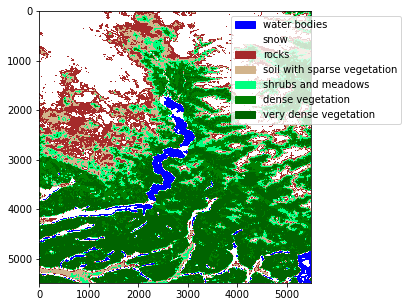

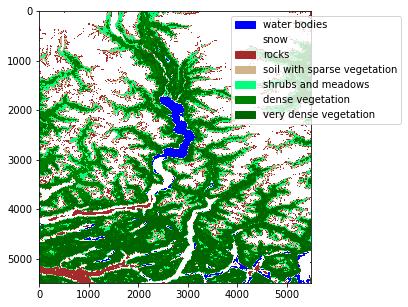

In [ ]:
#os.mkdir('/content/drive/My Drive/CSC462/blobdata/')
try:
    #import data from AZURE blob storage
    connect_str = "DefaultEndpointsProtocol=https;AccountName=maadistributed;AccountKey=UzTDFM1PfCz6erDVviGb5l1/pq952JnhBqn10sVPyML+NUR0MiN4jddH/pefm9iLGdy15jquvAFP/X1MA3+goA==;EndpointSuffix=core.windows.net" 
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)
    container_name = "eodata"
    container_client = blob_service_client.get_container_client(container_name)
    
    cmap = ListedColormap(["blue","white","brown","tan","springgreen","green","darkgreen"])
    norm = colors.BoundaryNorm([-1,-0.5,0,0.1,0.3,0.6,0.8,1],7)
    
    i =0
    blob_list = container_client.list_blobs()
    
    for blob in blob_list:
        blob_client = container_client.get_blob_client(blob)
        download_file_path = "/content/drive/My Drive/CSC462/blobdata/processedimg" + str(i) + ".tiff"
        downloadfile = open(download_file_path, "wb")
        downloadfile.write(blob_client.download_blob().readall())
        downloadfile.close()
        fig,ax = plt.subplots(figsize=(10,5))
        with rio.open(download_file_path, 'r') as mapfile:
            map = mapfile.read(1)
        
        map_plot = ax.imshow(map, cmap = cmap, norm= norm)

        legend_labels = {"blue":"water bodies", "white":"snow", "brown":"rocks", "tan": "soil with sparse vegetation", "springgreen":"shrubs and meadows", "green":"dense vegetation", "darkgreen": "very dense vegetation"}
        patches = [Patch(color=color, label = label) for color, label in legend_labels.items()]

        ax.legend( bbox_to_anchor=(1.35,1), handles=patches, facecolor="white")
        i = i + 1
        plt.show()

except Exception as ex:
    print('Exception: ')
    print(ex)

In [ ]:
# Create variables for destination coordinate system and the name of the projected raster
dst_crs = 'EPSG:4326' 

in_path = "/content/drive/My Drive/CSC462/blobdata/processedimg0.tiff"

out_path = "/content/drive/My Drive/CSC462/blobdata/processedimg0proj.tiff"


# Use rasterio package as rio to open and project the raster
with rio.open(in_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
 

    # Use rasterio package as rio to write out the new projected raster
    # Code uses loop to account for multi-band rasters
    with rio.open(out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)    

In [ ]:
# Use rasterio to import the reprojected data as img
with rio.open(out_path) as src:
    boundary = src.bounds
    img = src.read()
    nodata = src.nodata

In [ ]:

m = folium.Map(location=[51.3, -122.8],
                   tiles='Stamen Terrain', zoom_start = 13)

# Overlay raster called img using add_child() function (opacity and bounding box set)
m.add_child(folium.raster_layers.ImageOverlay(img[0], opacity=.7, bounds =[[51.3, -122.8], [51.3, -122.8]]))

# Display map 
m

In [ ]:
m = folium.Map([51.3, -122.8], zoom_start= 8)

imgfile = "/content/drive/My Drive/CSC462/blobdata/processedimg0proj.tiff"

img = folium.raster_layers.ImageOverlay(
    name = " NDVI projection",
    image=imgfile,
    bounds=[[51.3, -122.8],[51.3, -122.8]],
    opacity=0.5,
    interactive=True,
    zindex=1
)

folium.Popup("NDVI").add_to(img)
img.add_to(m)
folium.LayerControl().add_to(m)

In [ ]:
m